In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import sparse
from timesteppers import *
from field import *
from spatial import *

In [2]:
%run -i fokkerplanck.py

In [33]:
def ornstein_uhlenbeck_sol(gamma,D,mu,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b

def Wiener_sol(D,t,t0,x,x0):
    return 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))

def gaussian_ic(x,x0,y,y0,sigma=2.):
    r = (x-x0)**2. + (y-y0)**2.
    
    return np.exp(-r/sigma**2.)

In [17]:
'''
Test Wiener solution for Fokker-Planck equation on 2D grid
'''

def run_wiener(params, alpha, resolution):
    x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = Wiener_sol(D, t0, 0, x, x0) + 0*y


    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    mu = Array(domain, x*0 + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)

    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = Wiener_sol(D,diff.t+t0,t0,x,x0) + 0*y
    return x, target, p.data

/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: 

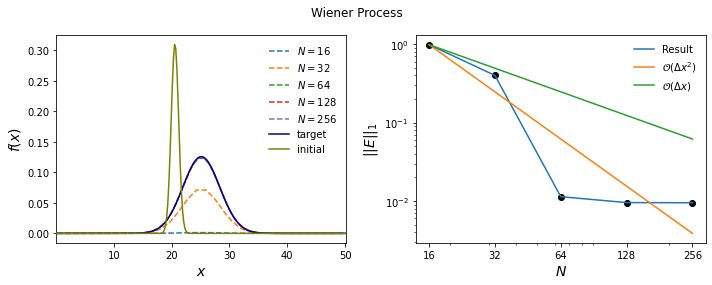

In [19]:
resolutions = [16, 32, 64, 128, 256]
alpha       = 0.8


### User parameters

# physical
x0 = 8*np.pi
t0 = 0.2
D  = 0.5

# numerical
spatial_order = 2

# domain
xmin = 0
xmax = 16*np.pi
ymin = 0
ymax = 16*np.pi

# solution
tmax = 10-1e-5

## combine params to send to wiener problem

params = x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax


fig, ax = plt.subplots(1, 2, figsize=(10,4))

error = []
norm  = 1.
for resolution in resolutions:
    x, target, sol = run_wiener(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[0].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--')
        
ax[0].plot(x, target[:,8],color='darkblue',label=r'target',zorder=10)
ax[0].plot(x, ic[:,8],color='olive',label=r'initial',zorder=10)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$x$',fontsize=14)
ax[0].set_ylabel(r'$f(x)$',fontsize=14)
ax[0].set_xlim(x[0],x[-1])

ax[1].plot(resolutions,error,label='Result')
ax[1].scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

ax[1].plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
ax[1].plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(frameon=False)

xtick_labels = np.array(resolutions).astype(str)
ax[1].set_xlabel(r'$N$',fontsize=14)
ax[1].set_ylabel(r'$||E||_1$',fontsize=14)
ax[1].set_xticks(resolutions)
ax[1].set_xticklabels(xtick_labels)

## extra plot stuff
#ax[0].set_title('test')

fig.suptitle('Wiener Process')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
if 0:
    plt.savefig('fp_wp_1d.pdf')

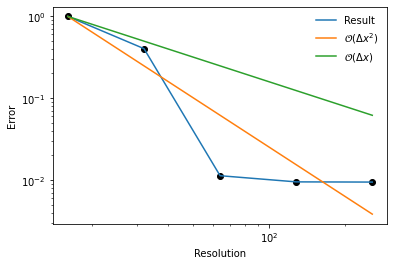

In [56]:
plt.plot(resolutions,error,label='Result')
plt.scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

plt.plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
plt.plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

plt.xticks(resolutions)
plt.xlabel('Resolution')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)

In [4]:
def ornstein_uhlenbeck_sol(gamma,D,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b



def run_ou(params, alpha, resolution):
    x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y

    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    mu = Array(domain, -1*gamma*x + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)
    
    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = ornstein_uhlenbeck_sol(gamma, D, diff.t+t0, x, x0) + 0*y
    return x, target, p.data, IC

/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: 

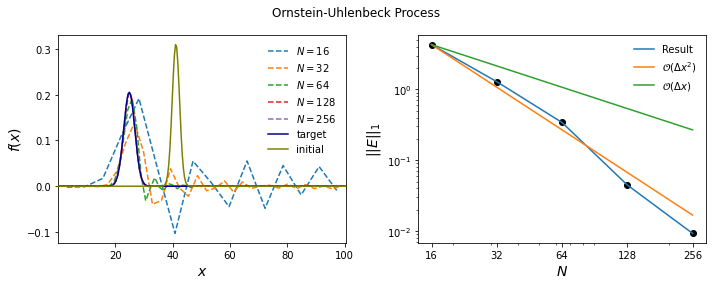

In [14]:
resolutions = [16, 32, 64, 128, 256]
alpha       = 0.2


### User parameters

# physical
x0    = 16*np.pi
t0    = 2
D     = 0.5
gamma = 0.1

# numerical
spatial_order = 2

# domain
xmin = 0
xmax = 32*np.pi
ymin = 0
ymax = 32*np.pi

# solution
tmax = 5-1e-5

## combine params to send to wiener problem

params = x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax

error = []
norm  = 1.

fig, ax = plt.subplots(1, 2, figsize=(10,4))

for resolution in resolutions:
    x, target, sol, ic = run_ou(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[0].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--', zorder=1)
    
ax[0].plot(x, target[:,8],color='darkblue',label=r'target',zorder=10)
ax[0].plot(x, ic[:,8],color='olive',label=r'initial',zorder=10)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$x$',fontsize=14)
ax[0].set_ylabel(r'$f(x)$',fontsize=14)
ax[0].set_xlim(x[0],x[-1])

ax[1].plot(resolutions,error,label='Result')
ax[1].scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

ax[1].plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
ax[1].plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(frameon=False)

xtick_labels = np.array(resolutions).astype(str)
ax[1].set_xlabel(r'$N$',fontsize=14)
ax[1].set_ylabel(r'$||E||_1$',fontsize=14)
ax[1].set_xticks(resolutions)
ax[1].set_xticklabels(xtick_labels)

## extra plot stuff
#ax[0].set_title('test')

fig.suptitle('Ornstein-Uhlenbeck Process')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
if 0:
    plt.savefig('fp_ou_1d.pdf')

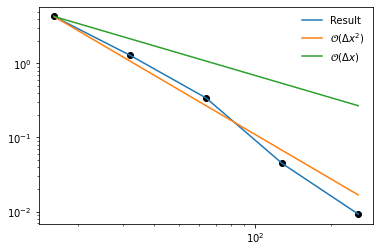

In [61]:
plt.plot(resolutions,error,label='Result')
plt.scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

plt.plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
plt.plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)

### Smoluchowski Diffusion Equation (Brownian motion under external force)
### $\frac{\partial p}{\partial t} = \left(\nabla^2D(\vec{r}) - \nabla\cdot\frac{\vec{F}(\vec{r})}{\gamma}\right)p$
### $\vec{F}(\vec{r})$ ~ external force
### $D(\vec{r})$ ~ diffusion coefficient
### $\gamma$ ~ scalar friction constant

### Can rewrite
### $\frac{\partial p}{\partial t} = \frac{\partial^2 (D(\vec{r})p)}{\partial x^2} + \frac{\partial^2 (D(\vec{r})p)}{\partial y^2} - \frac{\partial (F_x p/\gamma)}{\partial x} - \frac{\partial (F_y p/\gamma)}{\partial y}$

### Example of 1d solution, gravitational sedimentation
### $\frac{\partial p}{\partial t} = D\left[\frac{\partial^2 P}{\partial z^2} + \frac{mg}{kT}\frac{\partial P}{\partial z}\right]$

### We can expand to two dimensions
### $\frac{\partial p}{\partial t} = D\left[\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} + \frac{mg}{\sqrt{2}kT}(\frac{\partial p}{\partial x} + \frac{\partial p}{\partial y})\right]$

In [98]:
fig.suptitle?

Signature: fig.suptitle(t, **kwargs)
Docstring:
Add a centered title to the figure.

Parameters
----------
t : str
    The title text.

x : float, default 0.5
    The x location of the text in figure coordinates.

y : float, default 0.98
    The y location of the text in figure coordinates.

horizontalalignment, ha : {'center', 'left', right'}, default: 'center'
    The horizontal alignment of the text relative to (*x*, *y*).

verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: 'top'
    The vertical alignment of the text relative to (*x*, *y*).

fontsize, size : default: :rc:`figure.titlesize`
    The font size of the text. See `.Text.set_size` for possible
    values.

fontweight, weight : default: :rc:`figure.titleweight`
    The font weight of the text. See `.Text.set_weight` for possible
    values.

Returns
-------
text
    The `.Text` instance of the title.

Other Parameters
----------------
fontproperties : None or dict, optional
    A dict of font propert

In [38]:
def run_example_problem(params, alpha, resolution):
    x0, y0, t0, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(resolution,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    #IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y
    IC  = gaussian_ic(x, x0, y, y0, sigma=4)
    
    
    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    mu1 = Array(domain, -0.1*x)
    mu2 = Array(domain, -0.1*y)

    D_arr  = Array(domain, 0.5 + x*0 + y*0)#(x-x0 + 0.1)**(-2.) + (y - y0 + 0.1)**(-2.))
    
    mu_i = [mu1, mu2]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    return x, p.data, IC

In [95]:
resolution = 256
alpha       = 0.8


### User parameters

# physical
x0    = 4*np.pi
y0    = 4*np.pi

# numerical
spatial_order = 4

# domain
xmin = 0
xmax = 8*np.pi
ymin = 0
ymax = 8*np.pi

# solution
tmax = 0.1-1e-5

### Setting up the problem

grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
grid_y = UniformNonPeriodicGrid(resolution,[ymin, ymax])
domain = Domain([grid_x, grid_y])
x,y = domain.values()


#IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y
IC  = gaussian_ic(x, x0, y, y0)


p = Field(domain)
X = FieldSystem([p])


p.data[:] = np.copy(IC)

#mu = Array(domain, -0.1*(x+y))

D_arr  = Array(domain, 0.5 + x*0 + y*0)#(x-x0 + 0.1)**(-2.) + (y - y0 + 0.1)**(-2.))
mu1 = Array(domain, -0.5*np.sin(x) + 0.1*np.cos(y))
mu2 = Array(domain, -0.1*y + np.exp(-x))

mu_i = [mu2, mu1]
D_ij = [[D_arr, D_arr],
        [D_arr, D_arr]]
diff = FokkerPlanck_2D(X,mu_i,D_ij)

### Running


dt = alpha * domain.grids[0].dx

tmax = 4-1e-5

while diff.t < tmax:
    if diff.iter % 10 == 0: print(diff.iter, diff.t)
    if 0:#diff.iter % 10 == 0:
        print(diff.iter)
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(111)
        xm, ym = domain.plotting_arrays()
        pcm = ax.pcolormesh(xm, ym, p.data)
        ax.set_aspect(1)
        fig.colorbar(pcm)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.show()
        plt.clf()
        #fig.canvas.draw()
    diff.step(dt)



0 0.0
10 0.7853981633974483
20 1.5707963267948966
30 2.356194490192345
40 3.141592653589793
50 3.9269908169872414


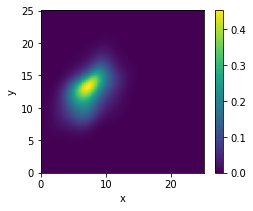

(256, 256)


<Figure size 432x288 with 0 Axes>

In [96]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, p.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()
plt.clf()

print(p.data.shape)
if 0:
    reference = np.copy(p.data)

In [97]:
resolutions = [16, 32, 64, 128]
alpha       = 0.8

### User parameters

# physical
x0    = 4*np.pi
y0    = 4*np.pi

# numerical
spatial_order = 4

# domain
xmin = 0
xmax = 8*np.pi
ymin = 0
ymax = 8*np.pi

# solution
tmax = 4-1e-5


solutions = []
for resolution in resolutions:
    ### Setting up the problem

    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(resolution,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    #IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y
    IC  = gaussian_ic(x, x0, y, y0)


    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    #mu = Array(domain, -0.1*(x+y))

    D_arr  = Array(domain, 0.5 + x*0 + y*0)#(x-x0 + 0.1)**(-2.) + (y - y0 + 0.1)**(-2.))
    mu1 = Array(domain, -0.5*np.sin(x) + 0.1*np.cos(y))
    mu2 = Array(domain, -0.1*y + np.exp(-x))

    mu_i = [mu2, mu1]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    
    while diff.t < tmax:
        diff.step(dt)
    solutions.append(p.data)

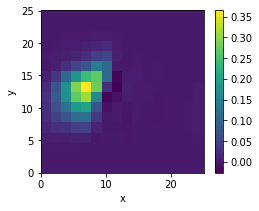

<Figure size 432x288 with 0 Axes>

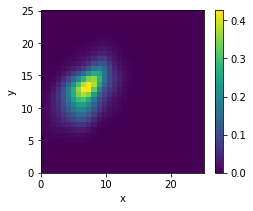

<Figure size 432x288 with 0 Axes>

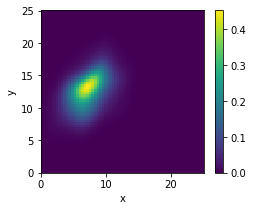

<Figure size 432x288 with 0 Axes>

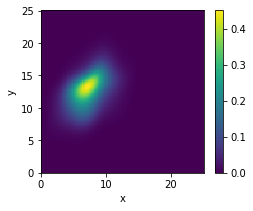

<Figure size 432x288 with 0 Axes>

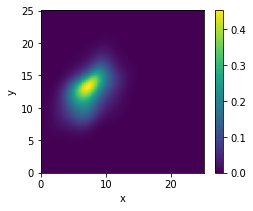

<Figure size 432x288 with 0 Axes>

In [99]:
for i in range(len(resolutions)):
    grid_x = UniformNonPeriodicGrid(resolutions[i],[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(resolutions[i],[ymin, ymax])
    domain = Domain([grid_x, grid_y])


    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    xm, ym = domain.plotting_arrays()
    pcm = ax.pcolormesh(xm, ym, solutions[i])
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    plt.clf()
    
grid_x = UniformNonPeriodicGrid(256,[xmin, xmax])
grid_y = UniformNonPeriodicGrid(256,[ymin, ymax])
domain = Domain([grid_x, grid_y])

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
xm, ym = domain.plotting_arrays()
pcm = ax.pcolormesh(xm, ym, reference)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()
plt.clf()


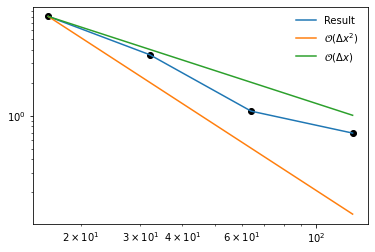

In [100]:
error = []
for i in range(len(resolutions)):
    res = resolutions[i]
    sol = solutions[i]
    grid_x = UniformNonPeriodicGrid(res,[xmin, xmax])
    dx = grid_x.values[1] - grid_x.values[0]    
    
    contracted_ref = reference[::ref_res//res,::ref_res//res]
    
    norm = 1
    error.append(np.sum(dx*dx*np.abs(sol-contracted_ref)**norm)**(1/norm))
    
    
plt.plot(resolutions,error,label='Result')
plt.scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

plt.plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
plt.plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)

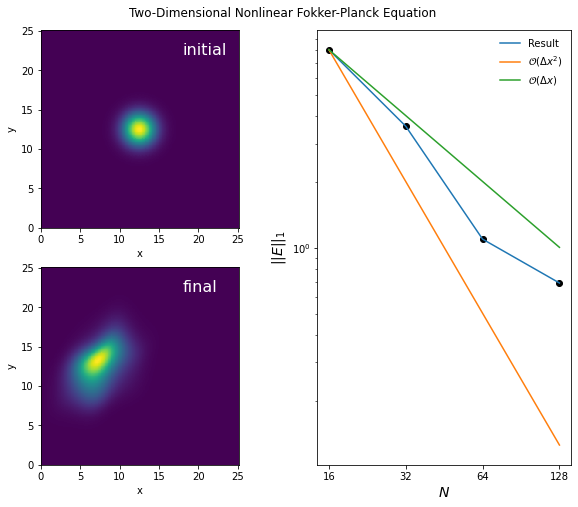

In [143]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,8))#constrained_layout=True)
spec = gridspec.GridSpec(ncols=2,nrows=2,figure=fig)
##, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True)

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[1, 0]))
ax.append(fig.add_subplot(spec[:, 1]))

ref_res = 256

grid_x = UniformNonPeriodicGrid(ref_res,[xmin, xmax])
grid_y = UniformNonPeriodicGrid(ref_res,[ymin, ymax])
domain = Domain([grid_x, grid_y])
x,y = domain.values()
IC  = gaussian_ic(x, x0, y, y0)



#fig, ax = plt.subplots(1, 2, figsize=(10,4))

xm, ym = domain.plotting_arrays()
pcm = ax[0].pcolormesh(xm, ym, IC)

ax[0].set_aspect(1)
#fig.colorbar(pcm)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].xaxis.set_visible('False')
    
pcm = ax[1].pcolormesh(xm, ym, reference)

ax[1].set_aspect(1)
#fig.colorbar(pcm)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

    
ref_res = 256

error = []
for i in range(len(resolutions)):
    res = resolutions[i]
    sol = solutions[i]
    grid_x = UniformNonPeriodicGrid(res,[xmin, xmax])
    dx = grid_x.values[1] - grid_x.values[0]    
    
    contracted_ref = reference[::ref_res//res,::ref_res//res]
    
    norm = 1
    error.append(np.sum(dx*dx*np.abs(sol-contracted_ref)**norm)**(1/norm))
ax[2].plot(resolutions,error,label='Result')
ax[2].scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

ax[2].plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
ax[2].plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].legend(frameon=False)

xtick_labels = np.array(resolutions).astype(str)
ax[2].set_xlabel(r'$N$',fontsize=14)
ax[2].set_ylabel(r'$||E||_1$',fontsize=14)
#ax[2].set_xticks([])
ax[2].set_xticks(resolutions,minor=True)
ax[2].set_xticks(resolutions,minor=False)
ax[2].set_xticklabels(xtick_labels)

## extra plot stuff
#ax[0].set_title('test')

ax[0].annotate('initial', (18,22),color='white',fontsize=16)
ax[1].annotate('final', (18,22),color='white',fontsize=16)

fig.suptitle('Two-Dimensional Nonlinear Fokker-Planck Equation',y=0.92)
#plt.subplots_adjust(wspace=0.0)
#plt.tight_layout()
if 1:
    plt.savefig('fp_2d.pdf')